In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
import random


## **Environments**

In [16]:

class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [17]:
import numpy as np
from tqdm import tqdm

def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        print('Choosing seed ', j+1, '...')
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))
        #print('Seed ', j+1, ' chosen: ', seeds[-1])
        #print('Reward: ', rewards[seeds[-1]])
        #print('-------------------')

    return seeds

In [18]:
class MatchingEnvironment(Environment):
    def __init__(self, reward_matrix):
        self.reward_matrix = reward_matrix
        # add a row and a column of zeros to the reward matrix to represent the case in which no match is made
        self.reward_matrix = np.hstack((self.reward_matrix, np.zeros((self.reward_matrix.shape[0], 1))))
        self.reward_matrix = np.vstack((self.reward_matrix, np.zeros((1, self.reward_matrix.shape[1]))))

        self.n_arms = reward_matrix.size
        self.t = 0

    def round(self, pulled_arms):
        try:
            rewards = [self.reward_matrix[pulled_arm] for pulled_arm in pulled_arms]
        except:
            print(pulled_arms)
        #iterate through all cells of rewards, if a cell is callable, call it and replace it with the result
        for i in range(len(rewards)):
            if callable(rewards[i]):
                rewards[i] = rewards[i]()

        return np.array(rewards)

In [19]:
class NonStationaryEnvironment(Environment):
    def __init__(self, probabilities, horizon):
        super().__init__(probabilities)
        self.t=0
        n_phases = len(self.probabilities)
        self.phase_size = horizon / n_phases

    def round(self, pulled_arm):
        current_phase = int(self.t / self.phase_size)
        p = self.probabilities[current_phase][pulled_arm]
        reward = np.random.binomial(1, p)
        self.t += 1
        return reward

## Learners

In [20]:

class Learner:

    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)
        self.t += 1

In [21]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)

    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            #n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)

In [22]:
class SW_UCBLearner(UCBLearner):
    def __init__(self, n_arms, window_size):
        super().__init__(n_arms)
        self.window_size = window_size
        # array showing sequence of pulled arms
        self.pulled_arms = np.array([])



    # get the list of unplayed arm in the last time_window
    def get_unplayed_arms(self, pulled_arms, time_window):
      all_arms = [i for i in range(self.n_arms)]
      if len(pulled_arms) < time_window:
        return list(all_arms)
      else:
        last_time_window = pulled_arms[-time_window:]
        played_arms = set(last_time_window)
        all_arms = [i for i in range(self.n_arms)]
        unplayed_arms = set(all_arms) - played_arms
        return list(unplayed_arms)


    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence

        self.upper_confidence_bound = upper_confidence_bound

        arms = [i for i in range(n_arms)] # get a list of all arms
        unplayed_arms_in_window = self.get_unplayed_arms(self.pulled_arms, self.window_size)
        # if there are unplayed arms in the most recent time window, play one of them at random
        if unplayed_arms_in_window != []:
            return random.choice(unplayed_arms_in_window)
        # else play the one with highest confidence bound
        else:
            return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

        for arm in range(self.n_arms):
            # count the number of times the arm has been played in the window
            n_samples = np.count_nonzero(np.array(self.pulled_arms[-window_size:]) == arm)
            # get the cumulative reward for the window if the arm was played at least once in the window
            cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            # empirical mean is computed
            self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
            # confidence decreasing linearly with number of samples in window
            self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000

        self.update_observations(pulled_arm, reward)

    def expectations(self):
        return self.empirical_means


In [23]:
class CUSUM:
  def __init__(self, M, eps, h):
    self.M = M #Length of window considered by CD
    self.eps = eps #Epsylon
    self.h = h #Threshold
    self.t = 0
    self.reference = 0 #Reference Mean
    self.g_plus = 0
    self.g_minus = 0

  def update(self, sample):
    self.t += 1


    # If time < CD window, update reference mean with new sample and return 0
    if self.t <= self.M:
      self.reference += sample/self.M
      return 0

    # If time > CD window, compute deviations and their cumulative sum
    else:
      s_plus = (sample - self.reference) - self.eps
      s_minus = -(sample - self.reference) - self.eps
      self.g_plus = max(0, self.g_plus + s_plus)
      self.g_minus = max(0, self.g_minus+ s_minus)
      # Return 1 if cusum of deviations are over threshold h
      return self.g_plus > self.h or self.g_minus > self.h

  def reset(self):
    # Reset the parameters if a detection occurs
    self.t = 0
    self.g_minus = 0
    self.g_plus = 0

  def Rounds_After_Last_Change(self):
    return self.t

In [24]:
class CUSUMUCB(UCBLearner):
    def __init__(self, n_arms, M=10, eps=0.01, h=5, alpha=0.1):
        super().__init__(n_arms)
        self.change_detection = [CUSUM(M, eps, h) for _ in range(n_arms)] #List of CUSUM objects
        self.detections = [[] for _ in range(n_arms)] # List of lists of detections per arm
        self.alpha = alpha
        self.pulled_arms = np.array([])
        # Initialize tau(a) as 0 for all arms.
        self.window_sizes = [0 for i in range(n_arms)]


    def pull_arm(self):
      upper_confidence_bound = self.empirical_means + self.confidence
      upper_confidence_bound[np.isinf(upper_confidence_bound)] = 1e3

      if np.random.binomial(1,1-self.alpha):
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])
      else:
        return random.randint(0,n_arms-1)




    def update(self, pulled_arm, reward):
      self.t += 1
      self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

              # Update the change detection for the arm pulled
      if self.change_detection[pulled_arm].update(reward):
        self.change_detection[pulled_arm].reset()


      for arm in range(self.n_arms):
        # update window_sizes for each arm
        self.window_sizes[arm] = self.change_detection[arm].Rounds_After_Last_Change()
        # count the number of times the arm has been played in the window
        n_samples = np.count_nonzero(np.array(self.pulled_arms[-self.window_sizes[arm]:]) == arm)
        # get the cumulative reward for the window if the arm was played at least once in the window
        cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
        # empirical mean is computed
        self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
        # confidence decreasing linearly with number of samples in window
        self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000


      self.update_observations(pulled_arm, reward)

    def expectations(self):
      return self.empirical_means

## Clairvoyant

In [25]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def generate_reward(mean, std_dev):
    return lambda: np.random.normal(mean, std_dev)

In [37]:

def get_reward(node_class, product_class, rewards_parameters):
    return 100-np.random.normal(rewards_parameters[0][node_class-1, product_class], rewards_parameters[1][node_class-1, product_class])

def clairvoyant(graph_probabilities, node_classes, rewards_parameters, n_exp):

    rewards_per_exp=np.zeros(n_exp)
    opt_seeds=greedy_algorithm(graph_probabilities, 3, 1000, 50)

    for i in tqdm(range(n_exp)):
        active_nodes=simulate_episode(graph_probabilities, opt_seeds, 50)[1]*node_classes

        #remove all zeros from array (nodes that were not activated)
        active_nodes=active_nodes[active_nodes!=0]

        #print(active_nodes)
        #compute rewards
        hun_matrix_dim=max(len(active_nodes), 9)

        rewards=np.zeros((hun_matrix_dim, hun_matrix_dim))

        for j in range(hun_matrix_dim):
            for l in range(hun_matrix_dim):
                if j<len(active_nodes) and l<9:
                    rewards[j,l]=get_reward(int(active_nodes[j]), l//3, rewards_parameters)
                else:
                    rewards[j,l]=0

        optimum= hungarian_algorithm(rewards)[0]
        optimum= 100-optimum #convert to reward
        #set all 100s to 0s
        optimum[optimum==100]=0
        #print(optimum)
        rewards_per_exp[i]=np.sum(optimum)
        #print('Optimum reward: ', np.sum(optimum))
        #print('-------------------')
    return np.mean(rewards_per_exp), np.std(rewards_per_exp)

## SCENARIO SET UP

#### Classes of product and Classes of customers

In [27]:
node_classes = 3
product_classes = 3
products_per_class = 3

means = np.random.uniform(10, 20, (3,3))
std_dev = np.ones((3,3))
rewards_parameters = (means, std_dev)

#### Probability tables (True Values) for each phase

In [28]:
n_arms = 30
n_phases = 3,
T = 365
window_size = int(T**0.5)
n_experiments = 50

def generate_graph_probabilities(n_nodes, edge_rate):
    graph_structure = np.random.binomial(1, edge_rate, (n_nodes, n_nodes))
    graph_probabilities = np.random.uniform(0.1, 0.9, (n_nodes, n_nodes)) * graph_structure
    return graph_probabilities

n_nodes = 30
edge_rate = 0.05
n_phases = 3

prob_phase1 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))
prob_phase2 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))
prob_phase3 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))

# array containing three (30*30) different probabilities tables.
p = np.stack((prob_phase1, prob_phase2, prob_phase3), axis=0)


# Array K will contain 30 arrays containing each 3 rows: row[i] of probability table of phase1, row[i] of the one of phase2, row[i] of the one of phase3.
K = np.array([p[:, i] for i in range(p.shape[1])])

## Probability Estimators

In [29]:
def SW_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, window_size=window_size, n_experiments=n_experiments):
    phases_len = int(T / n_phases)
    swucb_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        swucb_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        swucb_learner = SW_UCBLearner(n_arms=n_arms, window_size=window_size)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = swucb_learner.pull_arm()
            reward = swucb_env.round(pulled_arm)
            swucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = swucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [30]:
def CUSUM_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, n_experiments=n_experiments):
    phases_len = int(T / n_phases)
    cusum_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        cusum_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        cusum_learner = CUSUMUCB(n_arms=n_arms)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = cusum_learner.pull_arm()
            reward = cusum_env.round(pulled_arm)
            cusum_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = cusum_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

#### Estimating edges' probabilities with SW


In [32]:
SW_rounds_probabilities_for_each_arm = []

for index in range(len(K)):

  print("Learning for row:",index)
  estimates = SW_Generate_Probability_Estimates(K[index])
  SW_rounds_probabilities_for_each_arm.append(estimates)

SW_rounds_probabilities_for_each_arm = np.mean(SW_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


Learning for row: 1


100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


Learning for row: 2


100%|██████████| 50/50 [00:09<00:00,  5.43it/s]


Learning for row: 3


100%|██████████| 50/50 [00:08<00:00,  5.63it/s]


Learning for row: 4


100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


Learning for row: 5


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


Learning for row: 6


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


Learning for row: 7


100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


Learning for row: 8


100%|██████████| 50/50 [00:07<00:00,  6.38it/s]


Learning for row: 9


100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


Learning for row: 10


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Learning for row: 11


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Learning for row: 12


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


Learning for row: 13


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Learning for row: 14


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Learning for row: 15


100%|██████████| 50/50 [00:14<00:00,  3.45it/s]


Learning for row: 16


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Learning for row: 17


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Learning for row: 18


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


Learning for row: 19


100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Learning for row: 20


100%|██████████| 50/50 [00:09<00:00,  5.00it/s]


Learning for row: 21


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Learning for row: 22


100%|██████████| 50/50 [00:08<00:00,  6.11it/s]


Learning for row: 23


100%|██████████| 50/50 [00:08<00:00,  5.63it/s]


Learning for row: 24


100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Learning for row: 25


100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


Learning for row: 26


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]


Learning for row: 27


100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


Learning for row: 28


100%|██████████| 50/50 [00:07<00:00,  6.27it/s]


Learning for row: 29


100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


In [33]:
CUSUM_rounds_probabilities_for_each_arm = []

for index in range(len(K)):

  print("Learning for row:",index)
  estimates = CUSUM_Generate_Probability_Estimates(K[index])
  CUSUM_rounds_probabilities_for_each_arm.append(estimates)

CUSUM_rounds_probabilities_for_each_arm = np.mean(CUSUM_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


Learning for row: 1


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Learning for row: 2


100%|██████████| 50/50 [00:06<00:00,  7.38it/s]


Learning for row: 3


100%|██████████| 50/50 [00:05<00:00,  9.05it/s]


Learning for row: 4


100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Learning for row: 5


100%|██████████| 50/50 [00:05<00:00,  8.71it/s]


Learning for row: 6


100%|██████████| 50/50 [00:06<00:00,  7.17it/s]


Learning for row: 7


100%|██████████| 50/50 [00:05<00:00,  8.37it/s]


Learning for row: 8


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


Learning for row: 9


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Learning for row: 10


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


Learning for row: 11


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Learning for row: 12


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


Learning for row: 13


100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


Learning for row: 14


100%|██████████| 50/50 [00:05<00:00,  9.02it/s]


Learning for row: 15


100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


Learning for row: 16


100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


Learning for row: 17


100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


Learning for row: 18


100%|██████████| 50/50 [00:05<00:00,  8.83it/s]


Learning for row: 19


100%|██████████| 50/50 [00:06<00:00,  7.45it/s]


Learning for row: 20


100%|██████████| 50/50 [00:05<00:00,  8.79it/s]


Learning for row: 21


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


Learning for row: 22


100%|██████████| 50/50 [00:07<00:00,  6.38it/s]


Learning for row: 23


100%|██████████| 50/50 [00:06<00:00,  7.89it/s]


Learning for row: 24


100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


Learning for row: 25


100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


Learning for row: 26


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


Learning for row: 27


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Learning for row: 28


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Learning for row: 29


100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


In [34]:

def Reshape(LIST):
  # Convert the lists into a NumPy array
  array_of_lists = np.array(LIST)
  # Transpose the array to swap the axes
  transposed_array = array_of_lists.T
  # Split the transposed array into separate arrays along axis=1
  return np.split(transposed_array, transposed_array.shape[1], axis=1)

  # The output is a list of 365 NumPy arrays representing the evolution of the estimated probability table at each round.

'\n\n# Create a list that will contain, for each round, the probability table estimated.\n\n# Convert the lists into a NumPy array\narray_of_lists = np.array(rounds_probabilities_for_each_arm)\n# array_of_lists.shape = (10, 365)\n\n# Transpose the array to swap the axes\ntransposed_array = array_of_lists.T\n# transposed_array.shape = (365, 10)\n\n# Split the transposed array into separate arrays along axis=1\ntables = np.split(transposed_array, transposed_array.shape[1], axis=1)\n# tables is a list of 365 NumPy arrays, each containing the corresponding arrays from the 10 lists\n# tables is the evolution of the estimated probability table at each round!'

In [35]:
estimated_tables_SW = Reshape(SW_rounds_probabilities_for_each_arm)
estimated_tables_CUSUM = Reshape(CUSUM_rounds_probabilities_for_each_arm)

### COMPUTING REWARDS

### Reward - SW_UCB

In [38]:
n_exp = 10

SW_mean_rewards_per_round = []
SW_std_dev_rewards_per_round = []
for table in tqdm(range(len(estimated_tables_SW))):
  table = np.reshape(estimated_tables_SW[table],(30,30))
  clairvoyant_output = clairvoyant(table, node_classes, rewards_parameters, n_exp)
  SW_mean_rewards_per_round.append(clairvoyant_output[0])
  SW_std_dev_rewards_per_round.append(clairvoyant_output[1])


  0%|          | 0/365 [00:00<?, ?it/s]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:02<00:00, 13.06it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:02<00:00, 14.21it/s]

  0%|          | 1/365 [00:06<41:41,  6.87s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  9.26it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:02<00:00, 10.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:02<00:00, 11.82it/s]

  1%|          | 2/365 [00:15<47:50,  7.91s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 12.21it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:02<00:00, 11.31it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:03<00:00,  7.86it/s]

  1%|          | 3/365 [00:24<50:43,  8.41s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:02<00:00, 10.78it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:02<00:00, 10.38it/s]

  1%|          | 4/365 [00:32<49:58,  8.31s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  9.18it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  8.48it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:03<00:00,  9.73it/s]

  1%|▏         | 5/365 [00:42<53:22,  8.90s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 11.88it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  8.17it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:03<00:00,  7.81it/s]

  2%|▏         | 6/365 [00:52<55:38,  9.30s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 11.77it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  9.45it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.84it/s]

  2%|▏         | 7/365 [01:02<57:12,  9.59s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 10.59it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  8.51it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:03<00:00,  8.52it/s]

  2%|▏         | 8/365 [01:12<57:41,  9.70s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.86it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:03<00:00,  8.21it/s]

  2%|▏         | 9/365 [01:23<1:00:01, 10.12s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:03<00:00,  7.85it/s]

  3%|▎         | 10/365 [01:34<1:01:35, 10.41s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 11.17it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.88it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  7.43it/s]

  3%|▎         | 11/365 [01:46<1:02:44, 10.63s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 10.85it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  7.98it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.16it/s]

  3%|▎         | 12/365 [01:57<1:04:01, 10.88s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 10.85it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  8.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.95it/s]

  4%|▎         | 13/365 [02:09<1:05:05, 11.09s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:02<00:00, 10.69it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  7.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.39it/s]

  4%|▍         | 14/365 [02:20<1:05:24, 11.18s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.72it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  7.80it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  7.22it/s]

  4%|▍         | 15/365 [02:31<1:05:48, 11.28s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.41it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:03<00:00,  7.55it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  7.10it/s]

  4%|▍         | 16/365 [02:44<1:07:25, 11.59s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.60it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.73it/s]

  5%|▍         | 17/365 [02:57<1:09:29, 11.98s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.97it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.49it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.57it/s]

  5%|▍         | 18/365 [03:10<1:11:04, 12.29s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.11it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.53it/s]

  5%|▌         | 19/365 [03:23<1:12:26, 12.56s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.92it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.34it/s]

  5%|▌         | 20/365 [03:36<1:13:34, 12.80s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.15it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.06it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.59it/s]

  6%|▌         | 21/365 [03:49<1:14:07, 12.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.20it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.02it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.37it/s]

  6%|▌         | 22/365 [04:03<1:14:41, 13.07s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.17it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.88it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.31it/s]

  6%|▋         | 23/365 [04:16<1:15:22, 13.22s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.54it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  6.00it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.09it/s]

  7%|▋         | 24/365 [04:30<1:16:25, 13.45s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.09it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.33it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:04<00:00,  6.03it/s]

  7%|▋         | 25/365 [04:44<1:17:09, 13.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.18it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.95it/s]

  7%|▋         | 26/365 [04:59<1:18:22, 13.87s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.27it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.18it/s]

  7%|▋         | 27/365 [05:14<1:20:23, 14.27s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.18it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.71it/s]

  8%|▊         | 28/365 [05:30<1:22:17, 14.65s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.78it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.06it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.57it/s]

  8%|▊         | 29/365 [05:45<1:22:38, 14.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.82it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.48it/s]

  8%|▊         | 30/365 [06:00<1:23:21, 14.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.78it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.32it/s]

  8%|▊         | 31/365 [06:15<1:23:43, 15.04s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.05it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.74it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.46it/s]

  9%|▉         | 32/365 [06:31<1:24:25, 15.21s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.42it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.41it/s]

  9%|▉         | 33/365 [06:46<1:24:31, 15.28s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.20it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.99it/s]

  9%|▉         | 34/365 [07:02<1:25:13, 15.45s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.02it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.35it/s]

 10%|▉         | 35/365 [07:18<1:26:08, 15.66s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.48it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.14it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.31it/s]

 10%|▉         | 36/365 [07:34<1:25:32, 15.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.37it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.55it/s]

 10%|█         | 37/365 [07:50<1:26:04, 15.74s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.19it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.37it/s]

 10%|█         | 38/365 [08:05<1:25:37, 15.71s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.15it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.45it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.44it/s]

 11%|█         | 39/365 [08:21<1:24:39, 15.58s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.33it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.18it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.80it/s]

 11%|█         | 40/365 [08:37<1:24:56, 15.68s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.42it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.16it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.37it/s]

 11%|█         | 41/365 [08:52<1:24:55, 15.73s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:04<00:00,  6.14it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.36it/s]

 12%|█▏        | 42/365 [09:08<1:23:57, 15.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.40it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.01it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.94it/s]

 12%|█▏        | 43/365 [09:23<1:23:51, 15.63s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.50it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.33it/s]

 12%|█▏        | 44/365 [09:39<1:24:01, 15.71s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.49it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.84it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.27it/s]

 12%|█▏        | 45/365 [09:55<1:24:10, 15.78s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.59it/s]

 13%|█▎        | 46/365 [10:12<1:25:12, 16.03s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.45it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.82it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.25it/s]

 13%|█▎        | 47/365 [10:28<1:25:22, 16.11s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.07it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.66it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.46it/s]

 13%|█▎        | 48/365 [10:44<1:24:36, 16.01s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.35it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.34it/s]

 13%|█▎        | 49/365 [11:00<1:23:52, 15.92s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.14it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.72it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.37it/s]

 14%|█▎        | 50/365 [11:15<1:23:13, 15.85s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.40it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.65it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.39it/s]

 14%|█▍        | 51/365 [11:31<1:22:35, 15.78s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.07it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.89it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.52it/s]

 14%|█▍        | 52/365 [11:48<1:23:51, 16.07s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.18it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.91it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.30it/s]

 15%|█▍        | 53/365 [12:04<1:23:55, 16.14s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.45it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.62it/s]

 15%|█▍        | 54/365 [12:20<1:23:08, 16.04s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.11it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.34it/s]

 15%|█▌        | 55/365 [12:36<1:22:27, 15.96s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.09it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.26it/s]

 15%|█▌        | 56/365 [12:52<1:22:02, 15.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.86it/s]

 16%|█▌        | 57/365 [13:08<1:22:31, 16.08s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.01it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.59it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.22it/s]

 16%|█▌        | 58/365 [13:25<1:24:30, 16.52s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.21it/s]

 16%|█▌        | 59/365 [13:42<1:24:20, 16.54s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.88it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.02it/s]

 16%|█▋        | 60/365 [13:58<1:23:38, 16.45s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  8.02it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.27it/s]

 17%|█▋        | 61/365 [14:15<1:22:55, 16.37s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.77it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.16it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.26it/s]

 17%|█▋        | 62/365 [14:31<1:22:06, 16.26s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.96it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.90it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.66it/s]

 17%|█▋        | 63/365 [14:47<1:22:24, 16.37s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.81it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.29it/s]

 18%|█▊        | 64/365 [15:04<1:22:22, 16.42s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.14it/s]

 18%|█▊        | 65/365 [15:20<1:21:57, 16.39s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.01it/s]

 18%|█▊        | 66/365 [15:37<1:21:51, 16.43s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.64it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.04it/s]

 18%|█▊        | 67/365 [15:53<1:21:33, 16.42s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.30it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.50it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.22it/s]

 19%|█▊        | 68/365 [16:09<1:20:41, 16.30s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.14it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.38it/s]

 19%|█▉        | 69/365 [16:26<1:21:57, 16.61s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.57it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.54it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.24it/s]

 19%|█▉        | 70/365 [16:43<1:21:33, 16.59s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.68it/s]

 19%|█▉        | 71/365 [16:59<1:21:15, 16.58s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.97it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.02it/s]

 20%|█▉        | 72/365 [17:16<1:21:06, 16.61s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.97it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.77it/s]

 20%|██        | 73/365 [17:33<1:21:46, 16.80s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.12it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]

 20%|██        | 74/365 [17:51<1:23:13, 17.16s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]

 21%|██        | 75/365 [18:09<1:23:36, 17.30s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.69it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.67it/s]

 21%|██        | 76/365 [18:27<1:23:53, 17.42s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.98it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.93it/s]

 21%|██        | 77/365 [18:44<1:23:23, 17.37s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.81it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.11it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.01it/s]

 21%|██▏       | 78/365 [19:02<1:24:49, 17.73s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.60it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.17it/s]

 22%|██▏       | 79/365 [19:20<1:24:00, 17.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.76it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.76it/s]

 22%|██▏       | 80/365 [19:37<1:23:28, 17.57s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.73it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.47it/s]

 22%|██▏       | 81/365 [19:55<1:23:25, 17.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.00it/s]

 22%|██▏       | 82/365 [20:13<1:23:38, 17.73s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.59it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.60it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.71it/s]

 23%|██▎       | 83/365 [20:30<1:22:09, 17.48s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.72it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.96it/s]

 23%|██▎       | 84/365 [20:47<1:21:18, 17.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.14it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.66it/s]

 23%|██▎       | 85/365 [21:05<1:21:20, 17.43s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.31it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]

 24%|██▎       | 86/365 [21:22<1:21:42, 17.57s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.74it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.60it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.34it/s]

 24%|██▍       | 87/365 [21:40<1:21:08, 17.51s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.70it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.92it/s]

 24%|██▍       | 88/365 [21:57<1:20:36, 17.46s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.92it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.16it/s]

 24%|██▍       | 89/365 [22:16<1:21:59, 17.83s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.77it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.94it/s]

 25%|██▍       | 90/365 [22:34<1:21:59, 17.89s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.58it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.20it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.67it/s]

 25%|██▍       | 91/365 [22:52<1:21:17, 17.80s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.74it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.88it/s]

 25%|██▌       | 92/365 [23:09<1:19:56, 17.57s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]

 25%|██▌       | 93/365 [23:27<1:20:33, 17.77s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:03<00:00,  7.51it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.98it/s]

 26%|██▌       | 94/365 [23:44<1:19:43, 17.65s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.03it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.84it/s]

 26%|██▌       | 95/365 [24:02<1:19:26, 17.65s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.86it/s]

 26%|██▋       | 96/365 [24:19<1:18:46, 17.57s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.41it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]

 27%|██▋       | 97/365 [24:37<1:19:18, 17.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.93it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.02it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]

 27%|██▋       | 98/365 [24:55<1:19:22, 17.84s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.30it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.74it/s]

 27%|██▋       | 99/365 [25:13<1:18:55, 17.80s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.54it/s]

 27%|██▋       | 100/365 [25:31<1:19:15, 17.95s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.71it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.84it/s]

 28%|██▊       | 101/365 [25:50<1:20:24, 18.28s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.17it/s]

 28%|██▊       | 102/365 [26:09<1:19:55, 18.23s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.24it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.79it/s]

 28%|██▊       | 103/365 [26:26<1:18:48, 18.05s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.89it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.02it/s]

 28%|██▊       | 104/365 [26:45<1:20:03, 18.41s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]

 29%|██▉       | 105/365 [27:03<1:19:14, 18.29s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.06it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.65it/s]

 29%|██▉       | 106/365 [27:22<1:18:40, 18.22s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.25it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.64it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.42it/s]

 29%|██▉       | 107/365 [27:40<1:18:13, 18.19s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.03it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]

 30%|██▉       | 108/365 [27:58<1:18:38, 18.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.12it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.18it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.51it/s]

 30%|██▉       | 109/365 [28:16<1:17:59, 18.28s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.12it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.90it/s]

 30%|███       | 110/365 [28:34<1:16:06, 17.91s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.03it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.77it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.21it/s]

 30%|███       | 111/365 [28:52<1:16:30, 18.07s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.80it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]

 31%|███       | 112/365 [29:10<1:15:39, 17.94s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.20it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.43it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.83it/s]

 31%|███       | 113/365 [29:27<1:14:26, 17.72s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.27it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.84it/s]

 31%|███       | 114/365 [29:44<1:13:21, 17.54s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.13it/s]

 32%|███▏      | 115/365 [30:02<1:14:05, 17.78s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.09it/s]

 32%|███▏      | 116/365 [30:20<1:13:20, 17.67s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.72it/s]

 32%|███▏      | 117/365 [30:37<1:12:50, 17.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.28it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.56it/s]

 32%|███▏      | 118/365 [30:55<1:12:49, 17.69s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]

 33%|███▎      | 119/365 [31:14<1:13:31, 17.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.97it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.34it/s]

 33%|███▎      | 120/365 [31:31<1:12:47, 17.82s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.07it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.81it/s]

 33%|███▎      | 121/365 [31:49<1:11:56, 17.69s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.29it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.92it/s]

 33%|███▎      | 122/365 [32:06<1:11:12, 17.58s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.20it/s]

 34%|███▎      | 123/365 [32:24<1:11:38, 17.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.13it/s]

 34%|███▍      | 124/365 [32:42<1:11:07, 17.71s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.94it/s]

 34%|███▍      | 125/365 [32:59<1:10:05, 17.52s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  7.18it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.99it/s]

 35%|███▍      | 126/365 [33:16<1:09:09, 17.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.99it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.04it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.11it/s]

 35%|███▍      | 127/365 [33:33<1:08:17, 17.22s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.65it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.55it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.96it/s]

 35%|███▌      | 128/365 [33:49<1:07:32, 17.10s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.40it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.20it/s]

 35%|███▌      | 129/365 [34:07<1:08:17, 17.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.89it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.39it/s]

 36%|███▌      | 130/365 [34:25<1:07:46, 17.30s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:05<00:00,  5.11it/s]

 36%|███▌      | 131/365 [34:42<1:07:15, 17.25s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.05it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.60it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.92it/s]

 36%|███▌      | 132/365 [34:59<1:07:26, 17.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.37it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.16it/s]

 36%|███▋      | 133/365 [35:18<1:08:41, 17.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.47it/s]

 37%|███▋      | 134/365 [35:36<1:08:30, 17.79s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.72it/s]

 37%|███▋      | 135/365 [35:54<1:08:51, 17.96s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.78it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.13it/s]

 37%|███▋      | 136/365 [36:13<1:09:54, 18.32s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.14it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.09it/s]

 38%|███▊      | 137/365 [36:32<1:10:02, 18.43s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.47it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.64it/s]

 38%|███▊      | 138/365 [36:51<1:09:47, 18.45s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.69it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.22it/s]

 38%|███▊      | 139/365 [37:10<1:10:11, 18.64s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.60it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]

 38%|███▊      | 140/365 [37:29<1:10:40, 18.85s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.36it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.62it/s]

 39%|███▊      | 141/365 [37:48<1:10:17, 18.83s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.36it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]

 39%|███▉      | 142/365 [38:07<1:10:33, 18.98s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.91it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.71it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]

 39%|███▉      | 143/365 [38:26<1:10:38, 19.09s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.49it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.51it/s]

 39%|███▉      | 144/365 [38:45<1:10:09, 19.05s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]

 40%|███▉      | 145/365 [39:05<1:10:55, 19.34s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.16it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.00it/s]

 40%|████      | 146/365 [39:24<1:10:13, 19.24s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.35it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.46it/s]

 40%|████      | 147/365 [39:44<1:09:48, 19.21s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.87it/s]

 41%|████      | 148/365 [40:04<1:10:37, 19.53s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.20it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.43it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.08it/s]

 41%|████      | 149/365 [40:23<1:09:44, 19.37s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.29it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.75it/s]

 41%|████      | 150/365 [40:42<1:08:44, 19.19s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.72it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.11it/s]

 41%|████▏     | 151/365 [41:01<1:08:54, 19.32s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.24it/s]

 42%|████▏     | 152/365 [41:20<1:07:31, 19.02s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.96it/s]

 42%|████▏     | 153/365 [41:37<1:05:36, 18.57s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.16it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.38it/s]

 42%|████▏     | 154/365 [41:56<1:05:21, 18.59s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.53it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.71it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.96it/s]

 42%|████▏     | 155/365 [42:15<1:05:57, 18.84s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.28it/s]

 43%|████▎     | 156/365 [42:33<1:05:10, 18.71s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.46it/s]

 43%|████▎     | 157/365 [42:52<1:04:51, 18.71s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.94it/s]

 43%|████▎     | 158/365 [43:12<1:05:38, 19.02s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.13it/s]

 44%|████▎     | 159/365 [43:31<1:05:01, 18.94s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.42it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.72it/s]

 44%|████▍     | 160/365 [43:49<1:04:13, 18.80s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.77it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.07it/s]

 44%|████▍     | 161/365 [44:09<1:04:45, 19.04s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.22it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.00it/s]

 44%|████▍     | 162/365 [44:28<1:04:27, 19.05s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.43it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.47it/s]

 45%|████▍     | 163/365 [44:47<1:04:14, 19.08s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:06<00:00,  5.00it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.62it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]

 45%|████▍     | 164/365 [45:07<1:05:10, 19.46s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.34it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.21it/s]

 45%|████▌     | 165/365 [45:26<1:04:30, 19.35s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.23it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.40it/s]

 45%|████▌     | 166/365 [45:46<1:04:03, 19.31s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.43it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.88it/s]

 46%|████▌     | 167/365 [46:06<1:04:19, 19.49s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.43it/s]

 46%|████▌     | 168/365 [46:25<1:03:27, 19.33s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.91it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.14it/s]

 46%|████▋     | 169/365 [46:44<1:03:36, 19.47s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.56it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]

 47%|████▋     | 170/365 [47:04<1:03:21, 19.49s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.56it/s]

 47%|████▋     | 171/365 [47:23<1:02:36, 19.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.85it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.08it/s]

 47%|████▋     | 172/365 [47:43<1:02:42, 19.49s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.46it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.87it/s]

 47%|████▋     | 173/365 [48:03<1:02:51, 19.64s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.11it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.54it/s]

 48%|████▊     | 174/365 [48:22<1:02:06, 19.51s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.44it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.36it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.97it/s]

 48%|████▊     | 175/365 [48:42<1:02:16, 19.66s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]

 48%|████▊     | 176/365 [49:01<1:01:33, 19.54s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.22it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.51it/s]

 48%|████▊     | 177/365 [49:20<1:00:45, 19.39s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]

 49%|████▉     | 178/365 [49:40<1:01:05, 19.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.40it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.49it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.11it/s]

 49%|████▉     | 179/365 [49:59<59:57, 19.34s/it]  

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.38it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.64it/s]

 49%|████▉     | 180/365 [50:18<58:59, 19.13s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]

 50%|████▉     | 181/365 [50:37<59:08, 19.28s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.73it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]

 50%|████▉     | 182/365 [50:57<58:46, 19.27s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.49it/s]

 50%|█████     | 183/365 [51:16<58:13, 19.19s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.69it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.20it/s]

 50%|█████     | 184/365 [51:35<58:00, 19.23s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.54it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.75it/s]

 51%|█████     | 185/365 [51:55<58:10, 19.39s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.26it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.40it/s]

 51%|█████     | 186/365 [52:14<57:40, 19.33s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]

 51%|█████     | 187/365 [52:34<58:18, 19.65s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.86it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.61it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]

 52%|█████▏    | 188/365 [52:54<57:59, 19.66s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.19it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.97it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.36it/s]

 52%|█████▏    | 189/365 [53:13<57:22, 19.56s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.70it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.94it/s]

 52%|█████▏    | 190/365 [53:33<57:34, 19.74s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.67it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.62it/s]

 52%|█████▏    | 191/365 [53:54<57:46, 19.92s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.26it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.39it/s]

 53%|█████▎    | 192/365 [54:13<56:59, 19.77s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.75it/s]

 53%|█████▎    | 193/365 [54:34<57:24, 20.03s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.25it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.13it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.23it/s]

 53%|█████▎    | 194/365 [54:53<56:23, 19.79s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.37it/s]

 53%|█████▎    | 195/365 [55:13<55:47, 19.69s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.77it/s]

 54%|█████▎    | 196/365 [55:33<56:04, 19.91s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.22it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.29it/s]

 54%|█████▍    | 197/365 [55:52<55:22, 19.77s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.60it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]

 54%|█████▍    | 198/365 [56:13<55:28, 19.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.37it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.42it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.69it/s]

 55%|█████▍    | 199/365 [56:33<55:41, 20.13s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.01it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.35it/s]

 55%|█████▍    | 200/365 [56:53<54:55, 19.97s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.74it/s]

 55%|█████▌    | 201/365 [57:13<55:01, 20.13s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.97it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]

 55%|█████▌    | 202/365 [57:33<54:21, 20.01s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.19it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.31it/s]

 56%|█████▌    | 203/365 [57:53<53:36, 19.85s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.73it/s]

 56%|█████▌    | 204/365 [58:13<53:54, 20.09s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.07it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]

 56%|█████▌    | 205/365 [58:33<53:08, 19.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.65it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.30it/s]

 56%|█████▋    | 206/365 [58:52<52:32, 19.83s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]

 57%|█████▋    | 207/365 [59:13<52:28, 19.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.15it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.23it/s]

 57%|█████▋    | 208/365 [59:32<51:37, 19.73s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.69it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.41it/s]

 57%|█████▋    | 209/365 [59:51<51:13, 19.70s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]

 58%|█████▊    | 210/365 [1:00:12<51:42, 20.02s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.97it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.18it/s]

 58%|█████▊    | 211/365 [1:00:32<51:11, 19.94s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]

 58%|█████▊    | 212/365 [1:00:53<51:24, 20.16s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.65it/s]

 58%|█████▊    | 213/365 [1:01:14<51:39, 20.39s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.92it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.33it/s]

 59%|█████▊    | 214/365 [1:01:33<50:52, 20.22s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.49it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.11it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.90it/s]

 59%|█████▉    | 215/365 [1:01:54<50:46, 20.31s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.71it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.78it/s]

 59%|█████▉    | 216/365 [1:02:14<50:00, 20.14s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.34it/s]

 59%|█████▉    | 217/365 [1:02:33<49:14, 19.96s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.12it/s]

 60%|█████▉    | 218/365 [1:02:53<49:04, 20.03s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.73it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.74it/s]

 60%|██████    | 219/365 [1:03:14<48:57, 20.12s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.03it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.11it/s]

 60%|██████    | 220/365 [1:03:33<48:09, 19.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.85it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.97it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.35it/s]

 61%|██████    | 221/365 [1:03:53<47:37, 19.84s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.16it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.74it/s]

 61%|██████    | 222/365 [1:04:14<48:00, 20.15s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.81it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.22it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.94it/s]

 61%|██████    | 223/365 [1:04:34<47:31, 20.08s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.31it/s]

 61%|██████▏   | 224/365 [1:04:53<47:00, 20.00s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.04it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.64it/s]

 62%|██████▏   | 225/365 [1:05:15<47:29, 20.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.20it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.96it/s]

 62%|██████▏   | 226/365 [1:05:35<46:54, 20.25s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.90it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.36it/s]

 62%|██████▏   | 227/365 [1:05:54<46:15, 20.11s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]

 62%|██████▏   | 228/365 [1:06:15<46:06, 20.19s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.79it/s]

 63%|██████▎   | 229/365 [1:06:35<45:44, 20.18s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.95it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.30it/s]

 63%|██████▎   | 230/365 [1:06:55<45:14, 20.11s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.18it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]

 63%|██████▎   | 231/365 [1:07:16<45:13, 20.25s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.67it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.80it/s]

 64%|██████▎   | 232/365 [1:07:36<44:50, 20.23s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.27it/s]

 64%|██████▍   | 233/365 [1:07:56<44:23, 20.18s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.55it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.77it/s]

 64%|██████▍   | 234/365 [1:08:17<44:28, 20.37s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.71it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.77it/s]

 64%|██████▍   | 235/365 [1:08:37<44:08, 20.37s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.26it/s]

 65%|██████▍   | 236/365 [1:08:57<43:43, 20.34s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.59it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.74it/s]

 65%|██████▍   | 237/365 [1:09:18<43:56, 20.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.69it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.85it/s]

 65%|██████▌   | 238/365 [1:09:39<43:40, 20.63s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.66it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]

 65%|██████▌   | 239/365 [1:10:00<43:27, 20.69s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.37it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.57it/s]

 66%|██████▌   | 240/365 [1:10:22<43:44, 21.00s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.80it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.74it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.18it/s]

 66%|██████▌   | 241/365 [1:10:42<43:02, 20.83s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.86it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.79it/s]

 66%|██████▋   | 242/365 [1:11:03<42:53, 20.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.78it/s]

 67%|██████▋   | 243/365 [1:11:24<42:24, 20.86s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.84it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.18it/s]

 67%|██████▋   | 244/365 [1:11:44<41:52, 20.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.16it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.56it/s]

 67%|██████▋   | 245/365 [1:12:06<42:13, 21.12s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.71it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.16it/s]

 67%|██████▋   | 246/365 [1:12:27<41:27, 20.90s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.37it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.74it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.65it/s]

 68%|██████▊   | 247/365 [1:12:49<41:41, 21.20s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.64it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.69it/s]

 68%|██████▊   | 248/365 [1:13:10<41:06, 21.08s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.55it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.19it/s]

 68%|██████▊   | 249/365 [1:13:30<40:29, 20.95s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.64it/s]

 68%|██████▊   | 250/365 [1:13:52<40:28, 21.12s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.31it/s]

 69%|██████▉   | 251/365 [1:14:12<39:30, 20.80s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]

 69%|██████▉   | 252/365 [1:14:32<38:59, 20.70s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.81it/s]

 69%|██████▉   | 253/365 [1:14:53<38:36, 20.69s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.89it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.22it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.13it/s]

 70%|██████▉   | 254/365 [1:15:12<37:37, 20.33s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.60it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.45it/s]

 70%|██████▉   | 255/365 [1:15:32<36:54, 20.13s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.41it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.78it/s]

 70%|███████   | 256/365 [1:15:52<36:29, 20.09s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.44it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.06it/s]

 70%|███████   | 257/365 [1:16:11<35:45, 19.86s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.95it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:06<00:00,  4.40it/s]

 71%|███████   | 258/365 [1:16:31<35:04, 19.67s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.88it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.08it/s]

 71%|███████   | 259/365 [1:16:50<34:39, 19.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.39it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]

 71%|███████   | 260/365 [1:17:11<34:53, 19.94s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.69it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.19it/s]

 72%|███████▏  | 261/365 [1:17:31<34:37, 19.98s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.84it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]

 72%|███████▏  | 262/365 [1:17:51<34:13, 19.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.20it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.69it/s]

 72%|███████▏  | 263/365 [1:18:12<34:29, 20.28s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.01it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.98it/s]

 72%|███████▏  | 264/365 [1:18:32<34:00, 20.20s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.96it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.20it/s]

 73%|███████▎  | 265/365 [1:18:52<33:35, 20.16s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.63it/s]

 73%|███████▎  | 266/365 [1:19:13<33:52, 20.53s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.13it/s]

 73%|███████▎  | 267/365 [1:19:33<33:23, 20.45s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.01it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]

 73%|███████▎  | 268/365 [1:19:53<32:48, 20.30s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.46it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.59it/s]

 74%|███████▎  | 269/365 [1:20:15<32:51, 20.53s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.89it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.28it/s]

 74%|███████▍  | 270/365 [1:20:35<32:17, 20.40s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.05it/s]

 74%|███████▍  | 271/365 [1:20:55<32:04, 20.48s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.67it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]

 75%|███████▍  | 272/365 [1:21:16<31:57, 20.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.82it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.01it/s]

 75%|███████▍  | 273/365 [1:21:37<31:30, 20.55s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]

 75%|███████▌  | 274/365 [1:21:58<31:29, 20.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.77it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.87it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.72it/s]

 75%|███████▌  | 275/365 [1:22:19<31:16, 20.85s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.73it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.71it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  4.24it/s]

 76%|███████▌  | 276/365 [1:22:39<30:45, 20.73s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.73it/s]

 76%|███████▌  | 277/365 [1:23:01<30:46, 20.98s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.84it/s]

 76%|███████▌  | 278/365 [1:23:22<30:25, 20.98s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]

 76%|███████▋  | 279/365 [1:23:42<29:50, 20.82s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.49it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.75it/s]

 77%|███████▋  | 280/365 [1:24:03<29:32, 20.85s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.66it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.74it/s]

 77%|███████▋  | 281/365 [1:24:25<29:26, 21.03s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.82it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]

 77%|███████▋  | 282/365 [1:24:46<29:09, 21.08s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.39it/s]

 78%|███████▊  | 283/365 [1:25:08<29:15, 21.41s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.99it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.96it/s]

 78%|███████▊  | 284/365 [1:25:29<28:49, 21.35s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.66it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:09<00:00,  3.33it/s]

 78%|███████▊  | 285/365 [1:25:52<28:51, 21.64s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.89it/s]

 78%|███████▊  | 286/365 [1:26:13<28:23, 21.56s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.48it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.63it/s]

 79%|███████▊  | 287/365 [1:26:35<28:16, 21.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]

 79%|███████▉  | 288/365 [1:26:57<27:54, 21.75s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.56it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.77it/s]

 79%|███████▉  | 289/365 [1:27:19<27:38, 21.83s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.59it/s]

 79%|███████▉  | 290/365 [1:27:41<27:16, 21.82s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.99it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.81it/s]

 80%|███████▉  | 291/365 [1:28:02<26:39, 21.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.50it/s]

 80%|████████  | 292/365 [1:28:24<26:23, 21.69s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.80it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.52it/s]

 80%|████████  | 293/365 [1:28:45<26:00, 21.67s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.97it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]

 81%|████████  | 294/365 [1:29:07<25:28, 21.52s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.36it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.52it/s]

 81%|████████  | 295/365 [1:29:29<25:24, 21.78s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]

 81%|████████  | 296/365 [1:29:50<24:54, 21.66s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.89it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.57it/s]

 81%|████████▏ | 297/365 [1:30:12<24:32, 21.65s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.56it/s]

 82%|████████▏ | 298/365 [1:30:34<24:17, 21.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.98it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.70it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.85it/s]

 82%|████████▏ | 299/365 [1:30:55<23:40, 21.52s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.54it/s]

 82%|████████▏ | 300/365 [1:31:17<23:24, 21.62s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]

 82%|████████▏ | 301/365 [1:31:37<22:38, 21.22s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.62it/s]

 83%|████████▎ | 302/365 [1:31:59<22:25, 21.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.90it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.46it/s]

 83%|████████▎ | 303/365 [1:32:21<22:18, 21.59s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.90it/s]

 83%|████████▎ | 304/365 [1:32:42<21:45, 21.41s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.72it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.47it/s]

 84%|████████▎ | 305/365 [1:33:03<21:26, 21.44s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.72it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.46it/s]

 84%|████████▍ | 306/365 [1:33:25<21:14, 21.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.82it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.60it/s]

 84%|████████▍ | 307/365 [1:33:47<20:46, 21.49s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:06<00:00,  4.94it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.43it/s]

 84%|████████▍ | 308/365 [1:34:09<20:41, 21.79s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.80it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.80it/s]

 85%|████████▍ | 309/365 [1:34:30<20:09, 21.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.57it/s]

 85%|████████▍ | 310/365 [1:34:52<19:45, 21.55s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.02it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]

 85%|████████▌ | 311/365 [1:35:12<19:06, 21.24s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.92it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.83it/s]

 85%|████████▌ | 312/365 [1:35:33<18:37, 21.08s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.60it/s]

 86%|████████▌ | 313/365 [1:35:53<18:07, 20.91s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.86it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.81it/s]

 86%|████████▌ | 314/365 [1:36:14<17:36, 20.72s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.01it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.90it/s]

 86%|████████▋ | 315/365 [1:36:34<17:06, 20.53s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.49it/s]

 87%|████████▋ | 316/365 [1:36:55<16:59, 20.81s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.05it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.67it/s]

 87%|████████▋ | 317/365 [1:37:16<16:31, 20.65s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.76it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.60it/s]

 87%|████████▋ | 318/365 [1:37:37<16:24, 20.94s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.64it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.54it/s]

 87%|████████▋ | 319/365 [1:37:59<16:10, 21.09s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.02it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.72it/s]

 88%|████████▊ | 320/365 [1:38:20<15:54, 21.20s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.58it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.49it/s]

 88%|████████▊ | 321/365 [1:38:42<15:39, 21.35s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.97it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.71it/s]

 88%|████████▊ | 322/365 [1:39:02<15:10, 21.16s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.99it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.82it/s]

 88%|████████▊ | 323/365 [1:39:23<14:41, 20.99s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]

 89%|████████▉ | 324/365 [1:39:44<14:18, 20.95s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.76it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.64it/s]

 89%|████████▉ | 325/365 [1:40:05<13:58, 20.96s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.85it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]

 89%|████████▉ | 326/365 [1:40:26<13:43, 21.12s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.44it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.53it/s]

 90%|████████▉ | 327/365 [1:40:48<13:25, 21.20s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.66it/s]

 90%|████████▉ | 328/365 [1:41:09<13:03, 21.17s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.92it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.75it/s]

 90%|█████████ | 329/365 [1:41:30<12:39, 21.10s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.58it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.44it/s]

 90%|█████████ | 330/365 [1:41:52<12:27, 21.36s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.81it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.62it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.58it/s]

 91%|█████████ | 331/365 [1:42:14<12:11, 21.52s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:09<00:00,  3.24it/s]

 91%|█████████ | 332/365 [1:42:37<12:03, 21.94s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.90it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.55it/s]

 91%|█████████ | 333/365 [1:42:58<11:41, 21.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.49it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.75it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:09<00:00,  3.27it/s]

 92%|█████████▏| 334/365 [1:43:21<11:27, 22.16s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.45it/s]

 92%|█████████▏| 335/365 [1:43:43<11:01, 22.06s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.51it/s]

 92%|█████████▏| 336/365 [1:44:05<10:39, 22.07s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.88it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.40it/s]

 92%|█████████▏| 337/365 [1:44:27<10:19, 22.13s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.71it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.67it/s]

 93%|█████████▎| 338/365 [1:44:49<09:52, 21.93s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.41it/s]

 93%|█████████▎| 339/365 [1:45:11<09:33, 22.07s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.82it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.63it/s]

 93%|█████████▎| 340/365 [1:45:32<09:05, 21.81s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.37it/s]

 93%|█████████▎| 341/365 [1:45:55<08:47, 21.96s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]

 94%|█████████▎| 342/365 [1:46:16<08:19, 21.72s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.55it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.58it/s]

 94%|█████████▍| 343/365 [1:46:38<08:00, 21.83s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.67it/s]

 94%|█████████▍| 344/365 [1:47:00<07:39, 21.88s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.71it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.73it/s]

 95%|█████████▍| 345/365 [1:47:22<07:15, 21.79s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.57it/s]

 95%|█████████▍| 346/365 [1:47:44<06:56, 21.91s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.80it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]

 95%|█████████▌| 347/365 [1:48:05<06:30, 21.69s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.58it/s]

 95%|█████████▌| 348/365 [1:48:26<06:07, 21.61s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.38it/s]

 96%|█████████▌| 349/365 [1:48:49<05:51, 21.95s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.90it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.65it/s]

 96%|█████████▌| 350/365 [1:49:11<05:28, 21.92s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.41it/s]

 96%|█████████▌| 351/365 [1:49:33<05:09, 22.09s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.60it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.59it/s]

 96%|█████████▋| 352/365 [1:49:56<04:48, 22.18s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.54it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.43it/s]

 97%|█████████▋| 353/365 [1:50:18<04:24, 22.03s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:04<00:00,  6.01it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.63it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.49it/s]

 97%|█████████▋| 354/365 [1:50:39<04:01, 21.99s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.57it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.75it/s]

 97%|█████████▋| 355/365 [1:51:01<03:37, 21.80s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.55it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.37it/s]

 98%|█████████▊| 356/365 [1:51:23<03:17, 21.97s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.48it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:07<00:00,  3.76it/s]

 98%|█████████▊| 357/365 [1:51:44<02:54, 21.76s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.44it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.40it/s]

 98%|█████████▊| 358/365 [1:52:06<02:32, 21.79s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.64it/s]

 98%|█████████▊| 359/365 [1:52:27<02:09, 21.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.49it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.97it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.52it/s]

 99%|█████████▊| 360/365 [1:52:49<01:47, 21.60s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.51it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:09<00:00,  3.28it/s]

 99%|█████████▉| 361/365 [1:53:11<01:27, 21.85s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.67it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.55it/s]

 99%|█████████▉| 362/365 [1:53:33<01:05, 21.90s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.56it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:09<00:00,  3.29it/s]

 99%|█████████▉| 363/365 [1:53:56<00:44, 22.08s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.84it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:08<00:00,  3.46it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.61it/s]

100%|█████████▉| 364/365 [1:54:18<00:22, 22.10s/it]

Choosing seed  1 ...



100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


Choosing seed  2 ...



100%|██████████| 30/30 [00:07<00:00,  4.16it/s]


Choosing seed  3 ...



100%|██████████| 30/30 [00:08<00:00,  3.51it/s]

100%|██████████| 365/365 [1:54:39<00:00, 18.85s/it]


### Reward - CUSUM_UCB

In [39]:
CUSUM_mean_rewards_per_round = []
CUSUM_std_dev_rewards_per_round = []
for table in range(len(estimated_tables_CUSUM)):
  table = np.reshape(estimated_tables_CUSUM[table],(30,30))
  clairvoyant_output = clairvoyant(table, node_classes, rewards_parameters, n_exp)
  CUSUM_mean_rewards_per_round.append(clairvoyant_output[0])
  CUSUM_std_dev_rewards_per_round.append(clairvoyant_output[1])


Choosing seed  1 ...


100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.15it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1671.70it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.37it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 13.65it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1727.40it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.72it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 13.41it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1812.73it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.36it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 13.62it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1595.40it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.22it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.89it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2021.55it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.24it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.69it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1458.79it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.22it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 13.39it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2601.12it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.48it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.65it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1933.22it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.12it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.86it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 877.89it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.01it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.94it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1333.60it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.90it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1456.81it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.11it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 13.17it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1799.13it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1648.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.18it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 13.06it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1703.34it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.48it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.61it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2128.66it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.11it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.00it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2102.30it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2391.96it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.58it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1768.63it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.62it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 830.34it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.26it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.77it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1753.32it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.83it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1453.13it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.15it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.66it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2178.41it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.25it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.49it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1801.44it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.14it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.70it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1067.82it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.89it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.16it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1544.29it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.80it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.34it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1609.60it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.22it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.77it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1318.01it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.76it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.03it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1222.19it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 13.09it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.54it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1199.19it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1665.79it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.83it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.93it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1638.91it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.15it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1510.92it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.92it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.79it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1290.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.99it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.04it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1381.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.10it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.76it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1533.62it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.85it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1722.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.95it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.84it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1346.40it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.91it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.71it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1740.66it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.84it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.38it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1926.02it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.77it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.11it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1756.04it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.17it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.18it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1889.16it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.73it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.09it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1825.91it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.59it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.94it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1638.59it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.36it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.35it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1937.77it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.86it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1040.72it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.16it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 12.20it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1277.39it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.36it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.78it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1362.19it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.80it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.20it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1404.99it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.76it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2094.95it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.37it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1564.86it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.64it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.85it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1513.42it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.37it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.58it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1648.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.51it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1476.35it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.14it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1404.47it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.15it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.45it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1696.38it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.25it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1476.56it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1091.84it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.54it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.41it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1717.71it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.95it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 779.22it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.42it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.59it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1844.46it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.77it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1395.40it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.69it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1241.65it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.41it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.76it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2024.47it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.36it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.50it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1268.92it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.47it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1305.13it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.50it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.36it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1104.29it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.21it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1089.29it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.23it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1154.63it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.97it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.63it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1069.38it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.01it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.81it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1395.54it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.29it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.23it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1278.24it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.49it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.43it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1066.55it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.35it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.49it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 984.99it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.60it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.37it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1402.92it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.09it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.80it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1322.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.58it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1359.58it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.29it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.46it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1315.16it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.70it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.03it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1277.70it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.60it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.22it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1104.99it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.14it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1185.97it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.27it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1385.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.22it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1322.00it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.10it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.44it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 857.54it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.17it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.51it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1463.52it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.43it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1440.80it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.04it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.26it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1484.18it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.94it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1097.58it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.15it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1427.70it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.75it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1440.55it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.23it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 966.12it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.10it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1473.96it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.21it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.03it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1673.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.24it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.11it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1222.33it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.20it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.17it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 858.61it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.32it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.14it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1325.59it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.06it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.04it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1035.45it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1330.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.21it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.77it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1057.03it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.02it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.31it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1400.95it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.88it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1314.62it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.08it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1139.66it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.85it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.58it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1904.34it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.96it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.89it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 606.74it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.12it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1619.80it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.79it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.93it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1189.30it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.44it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 951.56it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.52it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.76it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1388.02it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.94it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.59it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1222.51it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.94it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1042.76it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.94it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.37it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1302.21it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.83it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1172.31it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.84it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.57it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1114.05it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.06it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.33it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 909.02it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.71it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.98it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 946.56it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.78it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1617.24it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.13it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 959.49it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.13it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 11.01it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1180.56it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.07it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.43it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1335.81it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 12.04it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.67it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1612.45it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.77it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.06it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1070.39it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.15it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1127.96it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.71it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.72it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1090.48it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.58it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.77it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 889.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.60it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 747.62it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.42it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1019.45it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.23it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1159.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.75it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.67it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1174.38it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.84it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:02<00:00, 10.08it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1092.69it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.13it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.81it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 804.65it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.68it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.97it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1066.74it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.35it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1117.74it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.05it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 746.52it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.37it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.06it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 885.04it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.64it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.72it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 977.56it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.60it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.07it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1466.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.86it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.33it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 990.04it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.69it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.11it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 849.31it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.89it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.70it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1302.98it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.62it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1336.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.66it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.58it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 989.55it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.70it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.50it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 940.28it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.35it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1389.95it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.40it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.93it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 963.92it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.02it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 834.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.62it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.15it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1085.40it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.62it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.81it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 850.75it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.19it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.70it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1480.99it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.79it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1164.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.80it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1275.68it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.26it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.90it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1061.77it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.24it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1005.71it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.66it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.92it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1015.52it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.96it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.83it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 993.49it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1190.85it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.66it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.63it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1106.59it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.60it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.90it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 940.49it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.47it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.92it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 899.78it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.96it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.79it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1352.52it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.64it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.84it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1443.47it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.60it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.32it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 966.01it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.17it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.39it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1203.15it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.14it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 773.86it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.09it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.76it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 806.58it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.89it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.76it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 834.31it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.98it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.35it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 923.27it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.37it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.67it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1498.34it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.39it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.46it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 945.90it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.57it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.43it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 883.16it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.05it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1469.42it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.82it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 837.84it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.02it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.38it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1012.63it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.24it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.07it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 899.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.37it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.74it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1146.86it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.52it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.57it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1262.96it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.04it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.57it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 874.71it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.48it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.92it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1310.47it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.09it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1068.04it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.19it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 943.39it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.28it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1097.70it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.10it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.47it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 728.38it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.09it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.02it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 921.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.35it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1131.67it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.08it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.38it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1015.82it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.10it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.80it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1053.26it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.22it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.39it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 980.18it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.30it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.85it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1190.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.03it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  9.04it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1364.09it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.27it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.13it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1030.24it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.28it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.38it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1311.17it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.24it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.80it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1059.78it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.05it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1136.67it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.17it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.84it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1048.31it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.22it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.05it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 750.09it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.05it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.98it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1136.95it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.85it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1452.32it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.02it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.25it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1009.75it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.05it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.13it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1169.93it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.10it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.30it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1086.04it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.95it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.03it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1074.69it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.11it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.93it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1038.91it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.68it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.97it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1201.94it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.78it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.44it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1089.15it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.45it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.28it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 827.80it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.16it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.37it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1040.36it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.04it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.34it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 998.98it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.07it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.14it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1031.71it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.32it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.19it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 841.06it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.76it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.95it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1362.01it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.62it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 797.32it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.95it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.15it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1063.65it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.03it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.21it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1306.80it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.62it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.33it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1426.54it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.96it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.36it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1256.83it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.99it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.11it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 873.67it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.71it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1354.75it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00, 10.00it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1087.76it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.52it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1153.42it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.80it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.81it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 722.65it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.03it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1003.52it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.24it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.46it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1094.46it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.08it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.31it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1075.79it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.58it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.43it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1242.90it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.66it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1125.47it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.50it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1194.89it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.28it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 843.74it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.18it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.85it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1475.72it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.09it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.96it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 927.43it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.98it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.06it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 877.14it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.06it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.64it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 845.10it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.73it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1161.82it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.55it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1173.10it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.49it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.09it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 896.60it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.75it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.96it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1314.09it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.81it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1080.12it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.65it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.06it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 925.51it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.60it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.16it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1407.53it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.76it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.89it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1020.81it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.81it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.92it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1111.90it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.89it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.96it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 593.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.42it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.03it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1065.41it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.53it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.07it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 918.31it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.38it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1100.29it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.81it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.00it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1222.19it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.96it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.18it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 967.34it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.94it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.19it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1152.95it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.82it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.56it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1031.73it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.61it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.65it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 544.33it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.86it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.82it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 852.80it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.00it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.17it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1111.75it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.41it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1272.12it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.21it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.48it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1191.36it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.01it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.28it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1118.90it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 11.02it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1297.06it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.79it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.78it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 740.13it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.82it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.48it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 909.65it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.80it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.57it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 720.49it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.00it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 824.42it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.54it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 824.19it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.87it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.20it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1299.79it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.79it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.27it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1332.96it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.61it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 909.43it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.80it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.34it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1074.25it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.86it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.04it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1025.75it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.61it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.80it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 915.91it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.58it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 921.70it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.73it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 894.96it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 815.22it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.77it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.25it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1119.62it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.67it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.22it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1016.60it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.73it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.53it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1255.74it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.89it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.92it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1263.15it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.64it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.72it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 815.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.23it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.10it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 770.76it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.82it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.25it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1061.77it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.32it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1060.37it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1199.71it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.56it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1085.62it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.66it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.19it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1118.15it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.67it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.36it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1309.21it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.32it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 684.29it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  7.47it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.17it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1070.28it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.47it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1376.22it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.90it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1245.93it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.76it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1340.03it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.81it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 702.48it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.65it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.74it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 919.80it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.64it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 758.19it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.25it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.64it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 966.01it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.53it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 2069.83it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.86it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1302.74it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.53it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.40it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1258.79it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.68it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.12it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 911.63it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.29it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.23it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 973.90it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.48it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.36it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1250.50it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.50it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.96it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1023.65it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.52it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.93it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1316.07it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.12it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  8.13it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 823.45it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.52it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.92it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 465.66it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.70it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.61it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1198.34it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.87it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.10it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1307.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.60it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.08it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1352.96it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.59it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 970.39it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.33it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.14it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1012.95it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.42it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.48it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1019.47it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.43it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.99it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 905.78it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.55it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.40it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1055.20it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.46it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.19it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1051.10it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.16it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.16it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 967.16it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.31it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 940.05it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.47it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 691.75it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.65it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.62it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 898.08it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.74it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.93it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1348.52it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  7.43it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.74it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 977.67it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.14it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.19it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 966.25it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.53it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.17it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1185.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.39it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1200.46it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.44it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 792.84it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.50it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 972.46it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.37it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.73it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 729.53it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.41it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.60it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 988.38it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.23it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.47it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 618.55it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.51it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.50it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1294.30it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.47it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.68it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1263.00it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.53it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.72it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 599.86it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.53it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 892.50it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.55it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 828.13it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  7.47it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.04it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 908.41it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.36it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1208.84it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.75it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.06it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1069.89it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.28it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.81it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 879.47it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.38it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 935.94it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.10it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.70it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 956.66it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.20it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.90it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 903.89it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.31it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.38it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1026.03it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.49it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.02it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 876.79it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.42it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.46it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 620.42it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.29it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.40it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 821.11it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.28it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1173.69it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.14it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.28it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 598.64it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.42it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.21it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 649.59it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.67it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  7.35it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 705.58it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.61it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 770.06it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  7.37it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.54it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1016.23it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  7.08it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:03<00:00,  7.53it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1121.41it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  7.56it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.83it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1153.99it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.40it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.27it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1098.99it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.16it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 925.57it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.23it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.85it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1028.32it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.26it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1107.76it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.83it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.64it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 745.97it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.93it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.68it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 866.23it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.06it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.49it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 925.89it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.09it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1066.76it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.08it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 692.83it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.30it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.70it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 827.69it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.80it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:05<00:00,  5.88it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1159.26it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.04it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.16it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 833.87it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.96it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.38it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 971.74it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.08it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 993.58it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.87it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 930.99it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.06it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 974.65it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.23it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 719.72it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:02<00:00, 10.23it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1002.53it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.85it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 966.54it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:03<00:00,  9.90it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Choosing seed  3 ...


100%|██████████| 10/10 [00:00<00:00, 1017.20it/s]


In [41]:
type(SW_mean_rewards_per_round)

list

In [42]:
import json


# Open the file in write mode and save the list as JSON
with open('C:\\Users\\jgras\\Desktop\\SW_estimates.json', 'w') as json_file:
    json.dump(SW_mean_rewards_per_round, json_file)


In [43]:
# Open the file in write mode and save the list as JSON
with open('C:\\Users\\jgras\\Desktop\\SW_std_dev.json', 'w') as json_file:
    json.dump(SW_std_dev_rewards_per_round, json_file)

In [44]:
# Open the file in write mode and save the list as JSON
with open('CUSUM_std_dev.json', 'w') as json_file:
    json.dump(CUSUM_std_dev_rewards_per_round, json_file)

In [45]:
with open('CUSUM_estimates.json', 'w') as json_file:
    json.dump(CUSUM_mean_rewards_per_round, json_file)

In [46]:
optimum_means = []
optimum_std_dev = []
for table in p:
  clairvoyant_output = clairvoyant(table, node_classes, rewards_parameters, 25)
  for i in range(int(T / n_phases)+1):
    optimum_means.append(clairvoyant_output[0])
    optimum_std_dev.append(clairvoyant_output[1])

optimum_means = optimum_means[:-1]
optimum_std_dev = optimum_std_dev[:-1]

Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Choosing seed  3 ...


100%|██████████| 25/25 [00:00<00:00, 630.46it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


Choosing seed  3 ...


100%|██████████| 25/25 [00:00<00:00, 579.29it/s]


Choosing seed  1 ...


100%|██████████| 30/30 [00:04<00:00,  6.40it/s]


Choosing seed  2 ...


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Choosing seed  3 ...


100%|██████████| 25/25 [00:00<00:00, 495.42it/s]


In [47]:
with open('Optimum_estimates.json', 'w') as json_file:
    json.dump(optimum_means, json_file)

with open('Optimum_std_dev.json', 'w') as json_file:
    json.dump(optimum_std_dev, json_file)

### Plotting Results

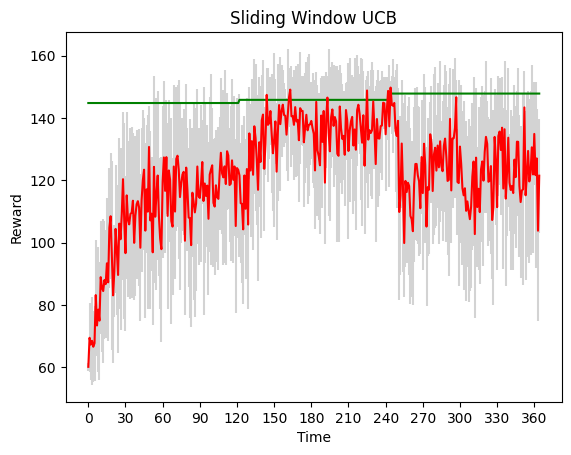

<Figure size 1000x600 with 0 Axes>

In [59]:


time_periods = range(len(SW_mean_rewards_per_round))

for t in time_periods:
    mean = SW_mean_rewards_per_round[t]
    std_dev = SW_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightgrey')


plt.plot(time_periods, optimum_means, color='green', linestyle='-')
plt.plot(time_periods, SW_mean_rewards_per_round, color='red', linestyle='-')



plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Sliding Window UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

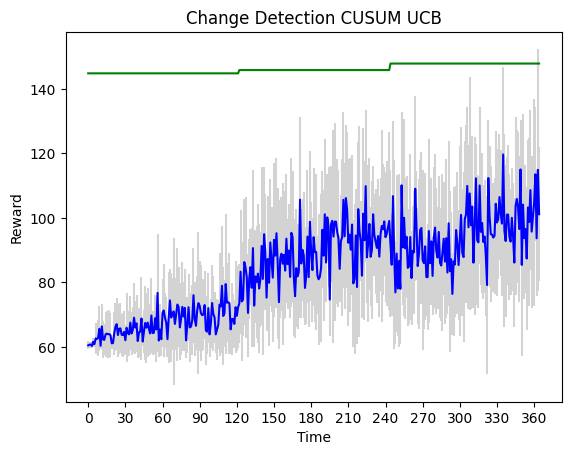

<Figure size 1000x600 with 0 Axes>

In [60]:


time_periods = range(len(CUSUM_mean_rewards_per_round))

for t in time_periods:
    mean = CUSUM_mean_rewards_per_round[t]
    std_dev = CUSUM_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightgrey')


plt.plot(time_periods, optimum_means, color='green', linestyle='-')
plt.plot(time_periods, CUSUM_mean_rewards_per_round, color='blue', linestyle='-')



plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Change Detection CUSUM UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

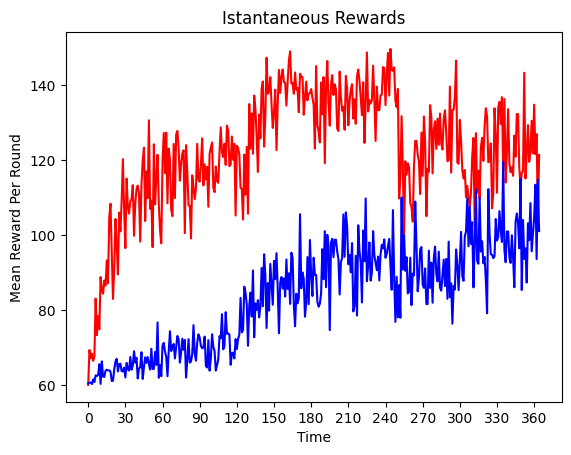

<Figure size 1000x600 with 0 Axes>

In [61]:

time_periods = range(len(SW_mean_rewards_per_round))

plt.plot(time_periods, SW_mean_rewards_per_round, color='red', linestyle='-', label = "SW_UCB")
plt.plot(time_periods, CUSUM_mean_rewards_per_round, color="blue",linestyle="-", label = "CD_UCB")

plt.xlabel('Time')
plt.ylabel('Mean Reward Per Round')
plt.title('Istantaneous Rewards')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()


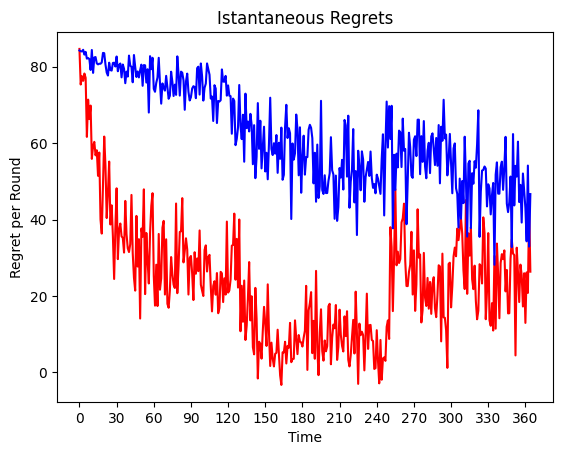

<Figure size 1000x600 with 0 Axes>

In [56]:
time_periods = range(len(SW_mean_rewards_per_round))

plt.plot(time_periods, [x - y for x, y in zip(optimum_means, SW_mean_rewards_per_round)], color='red', linestyle='-', label = "SW_UCB")
plt.plot(time_periods, [x - y for x, y in zip(optimum_means, CUSUM_mean_rewards_per_round)], color="blue",linestyle="-", label = "CD_UCB")

plt.xlabel('Time')
plt.ylabel('Regret per Round')
plt.title('Istantaneous Regrets')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()


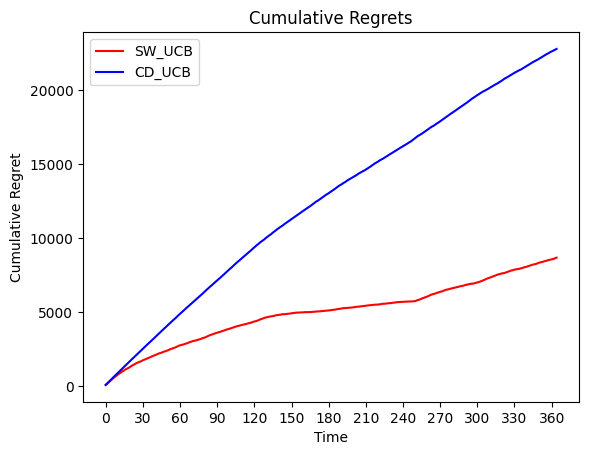

<Figure size 1000x600 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt

SW_cumulative_regret = [sum([x - y for x, y in zip(optimum_means[:t+1], SW_mean_rewards_per_round[:t+1])]) for t in time_periods]
CD_cumulative_regret = [sum([x - y for x, y in zip(optimum_means[:t+1], CUSUM_mean_rewards_per_round[:t+1])]) for t in time_periods]

plt.plot(time_periods, SW_cumulative_regret, color='red', linestyle='-', label="SW_UCB")
plt.plot(time_periods, CD_cumulative_regret, color="blue", linestyle="-", label="CD_UCB")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regrets')

plt.xticks(time_periods[::30])
plt.legend()

plt.figure(figsize=(10, 6))
plt.show()
